# Processes the SILO and NARCLIM data into one csv file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget

## Data Importing and Cleaning

### Concert .txt RCM file to .csv

In [2]:
import csv

# Input and output file paths
input_file = 'Input Data/1951_2014_all_vars_mgd.txt'  # Replace with your actual input file path
output_file = 'Input Data/NARCLIM_tall.csv'  # Replace with your desired output file path

# Initialize a list to hold data
data = []

# Open and read the .txt file
with open(input_file, 'r') as file:
    # Skip the header line
    next(file)
    # Read the rest of the lines
    for line in file:
        # Split each line into components based on whitespace
        fields = line.split()
        data.append(fields)

# Write the processed data to a .csv file
with open(output_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # Write header
    csvwriter.writerow(['date', 'name', 'value'])
    
    # Write data
    csvwriter.writerows(data)

print(f"Data has been successfully written to {output_file}")

Data has been successfully written to Input Data/NARCLIM_tall.csv


### Get NARCLIM Data

Convert from tall to wide

In [4]:
NARCLIM = pd.read_csv('Input Data/NARCLIM_tall.csv', parse_dates=['date'])
NARCLIM = NARCLIM.pivot(index='date', columns='name', values='value')
NARCLIM.index = NARCLIM.index.date
NARCLIM.rename(columns={'pr': 'p_RCM'}, inplace=True) # rename the 'pr' column to 'p_RCM' for clarity
NARCLIM.describe(include='all')
# replace 1e+20 with NaN
NARCLIM.replace(1e+20, np.nan, inplace=True)
NARCLIM.describe(include='all')
NARCLIM['p_RCM'] = NARCLIM['p_RCM'] * 86400 # convert from SI units to mm/day
NARCLIM.head()

name,CAPE,CAPEmax,CIN,CINmax,clivi,clt,clwvi,evspsbl,evspsblpot,hfls,...,zg300,zg400,zg500,zg600,zg70,zg700,zg750,zg850,zg925,zmla
1951-01-01,NaN,NaN,NaN,NaN,0.000060,12.5,0.003315,0.000013,0.001513,33.58153,...,9566.541,7495.741,5799.104,4357.022,18735.87,3101.249,2530.703,1478.512,756.1367,845.0737
1951-01-02,NaN,NaN,NaN,NaN,0.000079,25.0,0.000000,0.000014,0.000703,35.93560,...,9605.465,7526.680,5815.817,4365.528,18709.88,3112.448,2545.754,1499.015,775.4705,991.3351
1951-01-03,NaN,NaN,NaN,NaN,0.000100,12.5,0.000000,0.000014,0.001134,34.66610,...,9482.242,7437.816,5757.572,4329.994,18640.43,3088.378,2523.080,1473.241,744.7587,1111.6630
1951-01-04,NaN,NaN,NaN,NaN,0.001035,25.0,0.000000,0.000012,0.001391,29.73084,...,9377.226,7344.356,5678.355,4262.776,18588.86,3029.216,2468.967,1434.658,722.2295,1075.0860
1951-01-05,NaN,NaN,NaN,NaN,0.000000,12.5,0.000000,0.000012,0.000798,29.65585,...,9268.582,7265.858,5621.459,4224.815,18560.90,3009.613,2456.931,1435.457,728.8141,1071.2350


In [5]:
NARCLIM[['p_RCM']].describe(include='all')

name,p_RCM
count,23376.000000
mean,2.077594
std,5.919223
min,0.000000
25%,0.000000
50%,0.000241
75%,0.604211
max,86.776358


### Get Actuals rain data

In [7]:
rain_data = pd.read_csv('Input Data/SILO_-365514670.csv', parse_dates=[2], index_col=2)
# drop columns apart from AWAP
rain_data.rename(columns={'daily_rain': 'p_actual'}, inplace=True)
actuals = rain_data[['p_actual']]
actuals.describe(include='all')


,p_actual
count,49582.000000
mean,2.499119
std,6.218804
min,0.000000
25%,0.000000
50%,0.000000
75%,1.600000
max,111.200000


In [8]:
actuals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49582 entries, 1889-01-01 to 2024-10-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p_actual  49582 non-null  float64
dtypes: float64(1)
memory usage: 774.7 KB


## Missing Data

<AxesSubplot: title={'center': 'Missing data in NARCLIM'}, xlabel='name'>

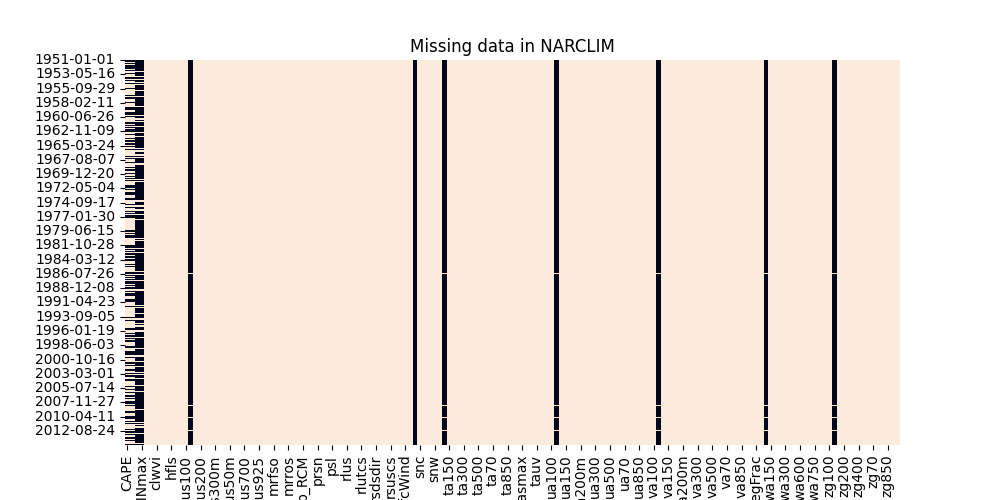

In [9]:
# Create matrix to plot missing data
plt.figure(figsize=(10, 5))
plt.title('Missing data in NARCLIM')
sns.heatmap(~NARCLIM.isnull(), cbar=False)

### Drop columns with na

In [10]:
NARCLIM.dropna(axis=1, inplace=True)
NARCLIM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23376 entries, 1951-01-01 to 2014-12-31
Columns: 146 entries, clivi to zmla
dtypes: float64(146)
memory usage: 26.2+ MB


In [12]:
cleaned_data = actuals.join(NARCLIM, how='inner')
cleaned_data.info()
cleaned_data.to_csv('Input Data/formatted_data_long.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23376 entries, 1951-01-01 to 2014-12-31
Columns: 147 entries, p_actual to zmla
dtypes: float64(147)
memory usage: 26.4 MB
